In [1]:
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support import expected_conditions as EC
import time
import json
import undetected_chromedriver as uc
import pandas as pd
from datetime import datetime
import os


from time import sleep

# from selenium import webdriver
# from selenium.webdriver import DesiredCapabilities
def scrape_reviews(url):
# make chrome log requests
    exe = "C:\\Users\\jonat\\Documents\\chromedriver_win32\\chromedriver.exe"
    desired_capabilities = DesiredCapabilities.CHROME
    desired_capabilities["goog:loggingPrefs"] = {"performance": "ALL"}  # newer: goog:loggingPrefs
    options = webdriver.ChromeOptions()
    
    # Chrome will start in Headless mode
    # options.add_argument('--headless')

    # Ignores any certificate errors if there is any
    options.add_argument("--ignore-certificate-errors")
    options.set_capability("goog:loggingPrefs", {"performance": "ALL"} )
    
    driver = webdriver.Chrome(
        service = Service(ChromeDriverManager().install()),
        options=options,
        # desired_capabilities=desired_capabilities
    )

    # fetch a site that does xhr requests
    # driver.get("https://www.tiket.com/review?product_type=TIXHOTEL&searchType=INVENTORY&inventory_id=infinity8-bali-506001655965152937&reviewSubmitColumn=RATING_SUMMARY&hideToolbar=null")
    driver.get(url)
    sleep(5)  # wait for the requests to take place

    # extract requests from logs
    page_class = "Pagination_page_number__iJiI3 HcPVsG_text HcPVsG_size_b2 HcPVsG_weight_bold"
    l = 0
    for page in driver.find_elements(By.XPATH, "//*[@class='Pagination_page_number__iJiI3 HcPVsG_text HcPVsG_size_b2 HcPVsG_weight_bold']"):
        try :
            l = int(page.text)
        except : 
            print("Error occur! page_text =", page.text)
    i = 0
    print("total pages:",l)
    # page_7 = 0
    
    for n in range(1,l+1):
        if n == 7:
            for page in driver.find_elements(By.XPATH, "//*[@class='Pagination_page_number__iJiI3 HcPVsG_text HcPVsG_size_b2 HcPVsG_weight_bold']"):
                if int(page.text) == 1:
                    page.click()
                    break
            for page in driver.find_elements(By.XPATH, "//*[@class='Pagination_page_number__iJiI3']"):
                page.click()
            
        page_btn = EC.presence_of_all_elements_located((By.XPATH, "//*[@class='Pagination_page_number__iJiI3 HcPVsG_text HcPVsG_size_b2 HcPVsG_weight_bold']"))

        for page in WebDriverWait(driver,30).until(page_btn):
            try :
                if int(page.text) == n:
                    page.click()
                    print(f"page {n} clicked!")
                    break
                # elif int(page.text) % 6 == 0:

            except :
                print("Error! page name =",page.text)
        # sleep(2.5)

        logs_raw = driver.get_log("performance")
        logs = [json.loads(lr["message"])["message"] for lr in logs_raw]

        def log_filter(log_):
            return (
                # is an actual response
                log_["method"] == "Network.responseReceived"
                # and json
                and "json" in log_["params"]["response"]["mimeType"]
            )
        
        for i,log in enumerate(filter(log_filter, logs)):
            request_id = log["params"]["requestId"]
            resp_url = log["params"]["response"]["url"]
            # print(f"Caught {resp_url}")
            # print(driver.execute_cdp_cmd("Network.getResponseBody", {"requestId": request_id}))
            f_name = f"{n}-{i}-{url.split('&')[2][13:]}.json"
            with open(os.path.join("files",f_name), "w") as f:
                # f.write(json.dumps(driver.execute_cdp_cmd("Network.getResponseBody", {"requestId": request_id})))
                # i+=1
                try :
                    data1 = json.loads(driver.execute_cdp_cmd("Network.getResponseBody", {"requestId": request_id})['body'])['data']
                    f.write(json.dumps(driver.execute_cdp_cmd("Network.getResponseBody", {"requestId": request_id})['body']))
                    # df1_data1 = pd.DataFrame(data1['content'])
                    # df2_data1 = pd.DataFrame(data1['comments'])
                    # df_data1 = df1_data1.join(df2_data1[['reviewId','value']].set_index('reviewId'), on='reviewId')
                    # df_data1.rename(columns={'value':'comment'}, inplace=True)
                    # df_data1.drop_duplicates(subset=['reviewId'], inplace=True)

                    # df_data1['ratingSummary'] = df_data1['ratingSummary'].astype('float32')
                    # df_data1['reviewDate'] = df_data1['reviewDate'].apply(lambda x : datetime.fromtimestamp(int(x)/1000))
                    # driver.quit()
                    # return df_data1.loc[:, ~df_data1.columns.isin(['reviewId','imageUrl'])], f_name
                except :
                    # print(data1.keys())
                    print("An error occur!")
                    pass

# scrape_reviews("https://www.tiket.com/review?product_type=TIXHOTEL&searchType=INVENTORY&inventory_id=nikhila-seminyak-bali-503001647484278823&reviewSubmitColumn=RATING_SUMMARY&hideToolbar=null")

In [2]:
df_data = pd.DataFrame()
questionTitles = []
for x in os.listdir("files"):
    try :
        with open(os.path.join("files", x), "r") as f:
            a = json.loads(json.loads(f.read()))['data']
 
            df1 = pd.DataFrame(a['userReviews']['content'])
            dates = [ 'startJourney', 'endJourney','reviewDate']
            for d in dates :
                df1[d] = pd.to_datetime(df1[d].apply(lambda x : datetime.fromtimestamp(int(x)/1000)))
                df1['ratingSummary'] = df1['ratingSummary'].astype('float32')

            l = list(set([y['questionTitle'] for x in df1['userReviewAnswers'].values for y in x ]))
            questionTitles += l

            for index, row in df1['userReviewAnswers'].items():
                for k in row:
                    key = k['questionTitle']
                    col = k['answerInteger']
                    df1.at[index, key] = col
            df_data = pd.concat([df_data, df1], ignore_index=True)

    # break
    except Exception as e: 
        print("error! file_name:", x)
        # print(e)
        # break

error! file_name: 1-1-nikhila-seminyak-bali-503001647484278823.json
error! file_name: 1-2-nikhila-seminyak-bali-503001647484278823.json
error! file_name: 1-3-nikhila-seminyak-bali-503001647484278823.json
error! file_name: 175-0-nikhila-seminyak-bali-503001647484278823.json
error! file_name: 232-0-nikhila-seminyak-bali-503001647484278823.json
error! file_name: 262-0-nikhila-seminyak-bali-503001647484278823.json
error! file_name: 79-0-nikhila-seminyak-bali-503001647484278823.json


In [24]:
df_data = pd.DataFrame()
questionTitles = []
for x in os.listdir("files"):
    
    try :
        with open(os.path.join("files", x), "r") as f:
            a = json.loads(json.loads(f.read()))['data']
 
            df1 = pd.DataFrame(a['userReviews']['content'])
            dates = ['startJourney', 'endJourney','reviewDate']
            df1.dropna(inplace=True)
            # for d in dates :
            #     df1[d] = pd.to_datetime(df1[d].apply(lambda x : datetime.fromtimestamp(int(x)/1000)))
            #     df1['ratingSummary'] = df1['ratingSummary'].astype('float32')

            l = list(set([y['questionTitle'] for x in df1['userReviewAnswers'].values for y in x ]))
            questionTitles += l

            for index, row in df1['userReviewAnswers'].items():
                for k in row:
                    key = k['questionTitle']
                    col = k['answerInteger']
                    df1.at[index, f"Rating{key}"] = col
                    df1.at[index, key] = k['answerString']
            df_data = pd.concat([df_data, df1], ignore_index=True)

    # break
    except Exception as e: 
        print("error! file_name:", x)
        # print(e)
        # break

C:\Users\jonat\AppData\Local\Temp\ipykernel_25436\1919559362.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Fantastis' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df1.at[index, key] = k['answerString']
C:\Users\jonat\AppData\Local\Temp\ipykernel_25436\1919559362.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Fantastis' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df1.at[index, key] = k['answerString']
C:\Users\jonat\AppData\Local\Temp\ipykernel_25436\1919559362.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Fantastis' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df1.at[index, key] = k['answerString']
C:\Users\jonat\AppD

error! file_name: 1-1-nikhila-seminyak-bali-503001647484278823.json
error! file_name: 1-2-nikhila-seminyak-bali-503001647484278823.json
error! file_name: 1-3-nikhila-seminyak-bali-503001647484278823.json


C:\Users\jonat\AppData\Local\Temp\ipykernel_25436\1919559362.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Fantastis' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df1.at[index, key] = k['answerString']
C:\Users\jonat\AppData\Local\Temp\ipykernel_25436\1919559362.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Fantastis' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df1.at[index, key] = k['answerString']
C:\Users\jonat\AppData\Local\Temp\ipykernel_25436\1919559362.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Fantastis' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df1.at[index, key] = k['answerString']
C:\Users\jonat\AppD

In [275]:
set(questionTitles)

{'Fasilitas',
 'Kebersihan',
 'Kepantasan harga',
 'Layanan',
 'Lokasi',
 'Pelayanan',
 'Saat nginep di sini, apa jenis perjalananmu?',
 'Sesuai Harga'}

In [154]:
df_data.columns

Index(['submitId', 'startJourney', 'endJourney', 'ratingSummary',
       'customerName', 'fake', 'comments', 'userReviewAnswers', 'userImages',
       'totalLike', 'reported', 'totalItems', 'likedByMe', 'reviewDate',
       'reviewSource', 'RatingKebersihan', 'Kebersihan', 'RatingPelayanan',
       'Pelayanan', 'RatingLokasi', 'Lokasi', 'RatingFasilitas', 'Fasilitas',
       'RatingSesuai Harga', 'Sesuai Harga', 'RatingKepantasan harga',
       'Kepantasan harga', 'RatingLayanan', 'Layanan',
       'RatingSaat nginep di sini, apa jenis perjalananmu?',
       'Saat nginep di sini, apa jenis perjalananmu?', 'stay_length'],
      dtype='object')

In [330]:
df_data[df_data.userImages.apply(lambda x:len(x)>0)]

submitId  startJourney    endJourney  ratingSummary  \
12    6247271ed5f0420001c6e250  1.648258e+12  1.648604e+12            5.0   
23    621f32f3b3230d00019c8dec  1.643852e+12  1.644197e+12            5.0   
27    621adcca19866400016b1552  1.645839e+12  1.645925e+12            5.0   
31    62144f2549b4440001b0cd33  1.644975e+12  1.645061e+12            5.0   
41    61fef60149b4440001a98d25  1.643765e+12  1.643938e+12            5.0   
...                        ...           ...           ...            ...   
1249  6319679992ccbe0001a45c53  1.661823e+12  1.661909e+12            5.0   
1257  630edd44d88985000160e865  1.653615e+12  1.653788e+12            5.0   
1305  62ba4ad02c88730001137554  1.654738e+12  1.654997e+12            5.0   
1329  624c5207984f03000156435f  1.648863e+12  1.649122e+12            5.0   
1330  624bbfc8319c9f0001c08e01  1.648172e+12  1.648258e+12            5.0   

                customerName   fake  \
12          Emma Kurnia Sari  False   
23                        CP  False   
27             Mentari Putri  False   
31      Lucia Anggun Lestari  False   
41                        CP  False   
...                      ...    ...   
1249         Winda Anggraeni  False   
1257     KUSMIYADI KUSMIYADI  False   
1305              Adam As ad  False   
1329  Andrianto Punomo Rekso  False   
1330        Emma Kurnia Sari  False   

                                               comments  \
12    [{'questionCode': 'comment', 'questionTitle': ...   
23    [{'questionCode': 'comment', 'questionTitle': ...   
27    [{'questionCode': 'comment', 'questionTitle': ...   
31    [{'questionCode': 'comment', 'questionTitle': ...   
41    [{'questionCode': 'comment', 'questionTitle': ...   
...                                                 ...   
1249  [{'questionCode': 'comment', 'questionTitle': ...   
1257  [{'questionCode': 'comment', 'questionTitle': ...   
1305  [{'questionCode': 'comment', 'questionTitle': ...   
1329  [{'questionCode': 'comment', 'questionTitle': ...   
1330  [{'questionCode': 'comment', 'questionTitle': ...   

                                      userReviewAnswers  \
12    [{'questionType': 'RATING', 'questionCode': 'c...   
23    [{'questionType': 'RATING', 'questionCode': 'c...   
27    [{'questionType': 'RATING', 'questionCode': 'c...   
31    [{'questionType': 'RATING', 'questionCode': 'c...   
41    [{'questionType': 'RATING', 'questionCode': 'c...   
...                                                 ...   
1249  [{'questionType': 'RATING', 'questionCode': 'c...   
1257  [{'questionType': 'RATING', 'questionCode': 'c...   
1305  [{'questionType': 'RATING', 'questionCode': 'f...   
1329  [{'questionType': 'RATING', 'questionCode': 'f...   
1330  [{'questionType': 'RATING', 'questionCode': 'c...   

                                             userImages  totalLike  ...  \
12    [{'key': 'primary', 'value': ['https://s-light...          1  ...   
23    [{'key': 'primary', 'value': ['https://s-light...          1  ...   
27    [{'key': 'primary', 'value': ['https://s-light...          0  ...   
31    [{'key': 'primary', 'value': ['https://s-light...          0  ...   
41    [{'key': 'primary', 'value': ['https://s-light...          1  ...   
...                                                 ...        ...  ...   
1249  [{'key': 'primary', 'value': ['https://s-light...          1  ...   
1257  [{'key': 'primary', 'value': ['https://s-light...          0  ...   
1305  [{'key': 'primary', 'value': ['https://s-light...          1  ...   
1329  [{'key': 'primary', 'value': ['https://s-light...          0  ...   
1330  [{'key': 'primary', 'value': ['https://s-light...          2  ...   

      Rating_Fasilitas  Fasilitas  Rating_Sesuai Harga  Sesuai Harga  \
12                 5.0  Fantastis                  NaN           NaN   
23                 5.0  Fantastis                  NaN           NaN   
27                 5.0  Fantastis                  NaN           NaN   
31                 5.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jonat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


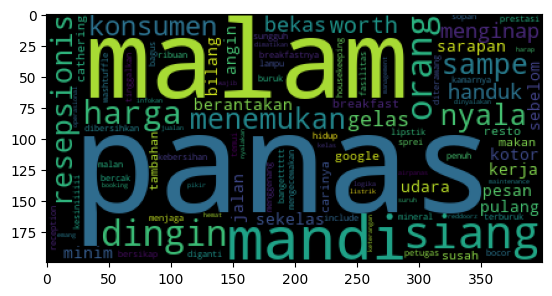

In [116]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nltk.download('stopwords')

stop = stopwords.words('indonesian')
strs = ' '.join(
    df_data[df_data['ratingSummary']<2].comments.apply(lambda x: x[0]['value']).values
).lower()
pattern = r'\b[a-zA-Z]{5,}\b'
tokens = nltk.regexp_tokenize(strs, f'{pattern}(?!-nya\\b)')
# print(tokens)
stop = stop+['overall', 'untuk', 'hotel','villa', 'kamar']

strs = " ".join([token for token in tokens if token not in stop])
plt.imshow(WordCloud().generate(strs))#strs.replace("  ", " ").replace("hotel", "").replace("villa", "").replace("vila","")))

In [133]:
pd.to_datetime(df_data['reviewDate'].apply(lambda x:datetime.fromtimestamp(x/1000)))

0      2023-09-28 11:32:32.943
1      2023-09-28 07:55:36.068
2      2023-09-27 23:11:15.174
3      2023-09-27 21:27:55.855
4      2023-09-27 19:10:55.177
                 ...          
1326   2022-04-10 13:58:02.772
1327   2022-04-08 07:58:47.886
1328   2022-04-07 13:30:15.005
1329   2022-04-05 21:28:23.604
1330   2022-04-05 11:04:24.202
Name: reviewDate, Length: 1331, dtype: datetime64[ns]

In [146]:
df_data.groupby(df_data['totalLike'])['stay_length'].mean().round('D')

totalLike
0    2 days
1    2 days
2    2 days
3    2 days
4    4 days
7    6 days
19   1 days
Name: stay_length, dtype: timedelta64[ns]

In [153]:
df_data.groupby(df_data['ratingSummary'].apply(round))['totalLike'].mean()

ratingSummary
1    2.900000
2    0.137255
3    0.070707
4    0.052257
5    0.225806
Name: totalLike, dtype: float64

In [ ]:
import nltk 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from wordcloud import WordCloud
nltk.download('stopwords')
# nltk.download('tagger')
nltk.download()
stop = stopwords.words('indonesian')
text = 'Selalu nyaman stay disini.. ga pernah bosan karena kebersihan nya.. Mulai dari Airy , baliez sampai Nikhila skg 😍.. staf ramah semua, kamar selalu di bersihkan tiap hari dan selalu dapat harga Gledekkk dari tiket.com Proses Check in out mudah dan cepat tanpa deposit apapun.. Sampe receptionist hapal karena sll stay dsana hhh pokoknya mantulll dah..'
pattern = r'\b[a-zA-Z]{3,}\b'
tokens = nltk.regexp_tokenize(text, pattern)
print(tokens)
p = nltk.pos_tag(tokens)

print(p)



In [ ]:
plt.pie(df_data[''])

In [335]:
df_data.comments.apply(lambda x: x[0]['value']).iloc[1330]

'Selalu nyaman stay disini.. ga pernah bosan karena kebersihan nya.. Mulai dari Airy , baliez sampai Nikhila skg 😍.. staf ramah semua, kamar selalu di bersihkan tiap hari dan selalu dapat harga Gledekkk dari tiket.com Proses Check in out mudah dan cepat tanpa deposit apapun.. Sampe receptionist hapal karena sll stay dsana hhh pokoknya mantulll dah..'

In [308]:
# df_data[df_data['userImages'].apply(lambda x : len(x) > 0)]
df_data[df_data.duplicated(subset=df_data.columns, keep=False)]

TypeError: unhashable type: 'list'

In [64]:
# Import the required modules
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
import time
import json
import undetected_chromedriver as uc
import pandas as pd


from time import sleep

# from selenium import webdriver
# from selenium.webdriver import DesiredCapabilities
def scrape(url):
# make chrome log requests
    desired_capabilities = DesiredCapabilities.CHROME
    desired_capabilities["goog:loggingPrefs"] = {"performance": "ALL"}  # newer: goog:loggingPrefs
    options = uc.ChromeOptions()
    
    # Chrome will start in Headless mode
    options.add_argument('headless')

    # Ignores any certificate errors if there is any
    options.add_argument("--ignore-certificate-errors")
    
    driver = uc.Chrome(
        options=options,
        desired_capabilities=desired_capabilities
    )

    # fetch a site that does xhr requests
    # driver.get("https://www.tiket.com/review?product_type=TIXHOTEL&searchType=INVENTORY&inventory_id=infinity8-bali-506001655965152937&reviewSubmitColumn=RATING_SUMMARY&hideToolbar=null")
    driver.get(url)
    sleep(5)  # wait for the requests to take place

    # extract requests from logs
    logs_raw = driver.get_log("performance")
    logs = [json.loads(lr["message"])["message"] for lr in logs_raw]

    def log_filter(log_):
        return (
            # is an actual response
            log_["method"] == "Network.responseReceived"
            # and json
            and "json" in log_["params"]["response"]["mimeType"]
        )
    i = 0
    for log in filter(log_filter, logs):
        request_id = log["params"]["requestId"]
        resp_url = log["params"]["response"]["url"]
        print(f"Caught {resp_url}")
        # print(driver.execute_cdp_cmd("Network.getResponseBody", {"requestId": request_id}))
        with open(f"net_{i}.json", "w") as f:
            # f.write(json.dumps(driver.execute_cdp_cmd("Network.getResponseBody", {"requestId": request_id})))
            # i+=1
            try :
                data1 = json.loads(driver.execute_cdp_cmd("Network.getResponseBody", {"requestId": request_id})['body'])['data']
                f.write(json.dumps(driver.execute_cdp_cmd("Network.getResponseBody", {"requestId": request_id})['body']))
                print(data1.keys())
                df1_data1 = pd.DataFrame(data1['content'])
                df2_data1 = pd.DataFrame(data1['comments'])
                df_data1 = df1_data1.join(df2_data1[['reviewId','value']].set_index('reviewId'), on='reviewId')
                df_data1.rename(columns={'value':'comment'}, inplace=True)
                df_data1.drop_duplicates(subset=['reviewId'], inplace=True)
                return df_data1.loc[:, ~df_data1.columns.isin(['imageUrl'])]
            except :
                print("error occur!")
                pass

df = scrape("https://www.tiket.com/review?product_type=TIXHOTEL&searchType=INVENTORY&inventory_id=infinity8-bali-506001655965152937&reviewSubmitColumn=RATING_SUMMARY&hideToolbar=null")


Caught https://www.tiket.com/ms-gateway/tix-review-core/verticalReview/internalReview?page=0&size=5&productType=TIXHOTEL&reviewSubmitColumn=RATING_SUMMARY&sortDirection=DESC&topic=&searchType=INVENTORY&inventoryId=infinity8-bali-506001655965152937
dict_keys(['area', 'city', 'region', 'country', 'userReviews', 'summaryReview', 'topics'])
error occur!
Caught https://www.tiket.com/ms-gateway/tix-review-core/verticalReview/image-with-comments?inventoryId=infinity8-bali-506001655965152937&productType=TIXHOTEL&page=0&size=100&lang=id
dict_keys(['content', 'pageable', 'comments', 'totalPages', 'totalElements', 'last', 'first', 'size', 'number', 'numberOfElements', 'empty'])


In [132]:
with open(f"net_0.json", "r") as f:
    x = json.loads(json.loads(f.read()))
    df = pd.DataFrame(x['data']['content'])
    df = df[df.duplicated(subset=['reviewId'], keep=False)]
    # print(df.head(5))
    print(df.shape)
    print(len(x['data']['content']))
    print(len(x['data']['comments']))
    print(x['data'].keys())
    print(x.keys())
    # print(x['data']['code'])
    print(x['data']['comments'][0].keys())

(69, 5)
100
53
dict_keys(['content', 'pageable', 'comments', 'totalPages', 'totalElements', 'last', 'first', 'size', 'number', 'numberOfElements', 'empty'])
dict_keys(['code', 'message', 'errors', 'data', 'serverTime', 'sessionData'])
dict_keys(['reviewId', 'questionCode', 'questionTitle', 'value'])


In [5]:
from datetime import datetime
df_data1 = df.drop_duplicates(subset='reviewId').drop(columns='reviewId')
df_data1['ratingSummary'] = df_data1['ratingSummary'].astype('float32')
df_data1['reviewDate'] = df_data1['reviewDate'].apply(lambda x : datetime.fromtimestamp(int(x)/1000))
# df_data1 = df_data1.set_index('reviewDate')
df_data1

reviewDate                    customerName  ratingSummary  \
0  2023-09-16 11:30:05.387                     nimas rofah            5.0   
1  2023-09-04 07:34:15.979               Alvin Suhardjhono            5.0   
2  2023-09-03 18:17:46.194                              AS            4.8   
3  2023-08-20 19:57:46.027             Ferditasus Meisaroh            4.0   
4  2023-08-16 20:28:13.342                              JA            4.0   
5  2023-07-22 17:18:35.503                RATIH RACHMATIKA            5.0   
6  2023-07-20 14:12:00.937                               H            5.0   
14 2023-07-03 11:28:33.837                              JT            4.8   
15 2023-06-17 23:38:01.036                              TL            5.0   
16 2023-06-14 04:48:07.425                              SW            5.0   
17 2023-06-07 19:55:26.204             Aprilliani Nasution            5.0   
18 2023-06-06 16:31:29.916                Nurainni Sorento            3.0   
20 2023-05-26 08:46:52.705                            Rudy            4.0   
22 2023-05-23 03:01:23.707                              DP            4.4   
23 2023-05-19 13:48:18.877               Natalia Verlyanti            5.0   
25 2023-05-14 18:07:15.314                     LIA APRILIA            5.0   
27 2023-05-14 07:47:00.219                              DP            4.0   
30 2023-05-07 20:10:20.466                              DP            5.0   
33 2023-04-30 19:27:50.039             Catur Meya Fitriana            5.0   
37 2023-04-30 10:40:01.707                              EA            4.6   
39 2023-04-24 22:33:08.915                    Asti Maulita            4.0   
40 2023-04-24 11:10:47.034                   Ratih Lestari            3.8   
41 2023-04-24 08:33:49.818                Ira Dewi Tandean            5.0   
42 2023-04-14 04:53:33.232                 Ester Silitonga            3.0   
45 2023-04-14 04:51:38.299                 Ester Silitonga            3.0   
48 2023-04-13 07:58:18.276                    Brenda Prima            5.0   
52 2023-03-22 09:47:05.673                     Hariana Nia            4.2   
56 2023-03-21 22:53:35.059           Fransisca Intandiasti            3.8   
57 2023-03-18 12:32:26.660  Asad Kurnia Afriansyah Wardani            5.0   
58 2023-03-16 10:50:19.320             Iskandar Febriyanto            5.0   
59 2023-03-13 16:34:45.477           Roulina Simanungkalit            4.0   
60 2023-03-13 16:33:23.650                              SL            4.0   
61 2023-03-04 15:10:10.097         Wimba Alif Cahyonugroho            4.0   
63 2023-02-19 16:47:47.831                Dameria Simamora            4.0   
64 2023-02-18 10:34:13.712                              SS            4.4   
65 2023-02-16 19:30:37.204                              TS            2.8   
67 2023-02-09 11:43:47.770                              IS            5.0   
68 2023-02-07 19:20:42.466         Ni Luh Putu Novita Sari            4.8   
71 2023-02-05 15:58:50.192          Galuh Thifal Anggraeni            5.0   
72 2023-02-05 15:58:03.276          Galuh Thifal Anggraeni            5.0   
73 2023-02-05 15:57:33.843          Galuh Thifal Anggraeni            4.0   
74 2023-02-05 15:55:05.808          Galuh Thifal Anggraeni            4.0   
75 2023-01-27 16:46:53.449                   Anita Natalia            5.0   
76 2023-01-16 12:52:43.863           Thomas Friedrich Kamm            3.8   
80 2023-01-15 21:08:27.372           Sansan Hendi Marliana            4.6   
81 2023-01-13 00:10:15.945                              GH            5.0   
85 2023-01-12 19:16:36.039                              MS            3.0   
86 2023-01-10 20:55:52.607                Rustrianti Putri            4.0   
89 2023-01-10 12:43:19.593                              AK            5.0   
90 2023-01-06 23:27:13.521                              SP            4.8   
91 2023-01-04 20:11:27.201             Sumartono Sumartono            3.8   
93 2023-01-0

In [16]:
datetime.now().year

2023

In [19]:

df_data1['year'] = df_data1.reviewDate.dt.year
df_data1['month'] = df_data1.reviewDate.dt.month
df_data1['day'] = df_data1.reviewDate.dt.day

df_data1[df_data1['year'] == datetime.now().year].groupby(['month'])['ratingSummary'].mean()

month
1    4.400000
2    4.333333
3    4.285714
4    4.175000
5    4.566667
6    4.500000
7    4.933333
8    4.000000
9    4.933333
Name: ratingSummary, dtype: float32

In [25]:
df_data1['commented'] = df_data1['comment'].apply(lambda x : False if x=="" else True)

In [31]:
df_data1.groupby('commented')['ratingSummary'].count().sort_values()

commented
False     8
True     45
Name: ratingSummary, dtype: int64

In [23]:
df_data['RatingKebersihan']

KeyError: 'RatingKebersihan'

In [55]:
df_data['Saat nginep di sini, apa jenis perjalananmu?'].fillna('Lainnya', inplace=True)

In [56]:
df_data.groupby(['Saat nginep di sini, apa jenis perjalananmu?']).count()['ratingSummary']

Saat nginep di sini, apa jenis perjalananmu?
Keperluan Medis        1
Lainnya              862
Perjalanan Bisnis     26
Trip Keluarga        113
Trip Pasangan        121
Trip Solo            126
Trip bareng Teman     82
Name: ratingSummary, dtype: int64

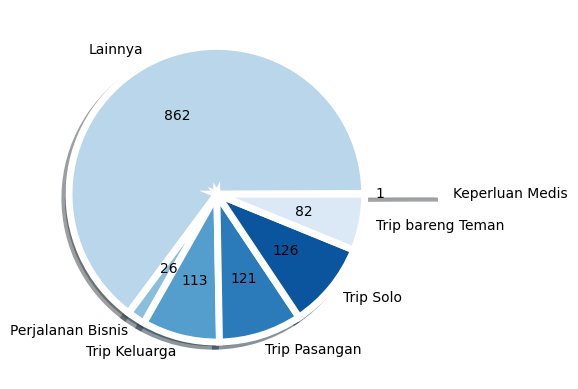

In [155]:
import seaborn as sns
h = df_data.groupby(['Saat nginep di sini, apa jenis perjalananmu?']).count()['ratingSummary'].values
explode = [0.5,0,0,0,0,0,0]
plt.pie(
    h, 
    # autopct='%1.2f%%',
    labels=df_data.groupby(['Saat nginep di sini, apa jenis perjalananmu?']).count().index,
    shadow = True,
    explode=explode,
    autopct = lambda p : f'{round(p*sum(h)/100)}',
    colors = sns.color_palette("Blues"),
    wedgeprops={'linewidth':5.0, 'edgecolor':'white'}
)
plt.show()

In [83]:
df_data.columns

Index(['submitId', 'startJourney', 'endJourney', 'ratingSummary',
       'customerName', 'fake', 'comments', 'userReviewAnswers', 'userImages',
       'totalLike', 'reported', 'totalItems', 'likedByMe', 'reviewDate',
       'reviewSource', 'RatingKebersihan', 'Kebersihan', 'RatingPelayanan',
       'Pelayanan', 'RatingLokasi', 'Lokasi', 'RatingFasilitas', 'Fasilitas',
       'RatingSesuai Harga', 'Sesuai Harga', 'RatingKepantasan harga',
       'Kepantasan harga', 'RatingLayanan', 'Layanan',
       'RatingSaat nginep di sini, apa jenis perjalananmu?',
       'Saat nginep di sini, apa jenis perjalananmu?'],
      dtype='object')

In [86]:
# import datetime as dts
# length = (datetime.fromtimestamp(df_data['endJourney'][0]/1000) - datetime.fromtimestamp(df_data['startJourney'].iloc[0]/1000)).days

for index, row in df_data.iterrows():
    df_data.at[index,'stay_length'] = datetime.fromtimestamp(row['endJourney']/1000) - datetime.fromtimestamp(row['startJourney']/1000)

In [93]:
df_data[df_data['stay_length'].apply(lambda x:x.days).apply(lambda x: x>3)]

submitId  startJourney    endJourney  ratingSummary  \
6     64dad21453225c00015a0112  1.691107e+12  1.691453e+12            5.0   
12    6247271ed5f0420001c6e250  1.648258e+12  1.648604e+12            5.0   
15    62401983319c9f000111ceda  1.646098e+12  1.646444e+12            5.0   
21    622dc650c63c37000150076c  1.646617e+12  1.647135e+12            5.0   
23    621f32f3b3230d00019c8dec  1.643852e+12  1.644197e+12            5.0   
...                        ...           ...           ...            ...   
1286  62f147a1f915ff0001f667bb  1.644975e+12  1.645753e+12            5.0   
1292  62e7170ee5fb2f00014782a2  1.657676e+12  1.658021e+12            5.0   
1294  62e3295eedb6b900012a7ba8  1.657762e+12  1.658108e+12            5.0   
1299  62d929c1804ada00018d1678  1.657676e+12  1.658194e+12            5.0   
1312  6294e31180875e0001bfbb6f  1.653529e+12  1.653874e+12            5.0   

                       customerName   fake  \
6            Yehuda Imanuel Sadikun  False   
12                 Emma Kurnia Sari  False   
15    NI WAYAN DESY PUTRI HANDAYANI  False   
21                               AP  False   
23                               CP  False   
...                             ...    ...   
1286                             CS  False   
1292          Delisa Prita Deynanti  False   
1294                      Faldos DL  False   
1299             MUH ADAM PARAWANSA  False   
1312             Novianty Nusaputra  False   

                                               comments  \
6     [{'questionCode': 'comment', 'questionTitle': ...   
12    [{'questionCode': 'comment', 'questionTitle': ...   
15    [{'questionCode': 'comment', 'questionTitle': ...   
21    [{'questionCode': 'comment', 'questionTitle': ...   
23    [{'questionCode': 'comment', 'questionTitle': ...   
...                                                 ...   
1286  [{'questionCode': 'comment', 'questionTitle': ...   
1292  [{'questionCode': 'comment', 'questionTitle': ...   
1294  [{'questionCode': 'comment', 'questionTitle': ...   
1299  [{'questionCode': 'comment', 'questionTitle': ...   
1312  [{'questionCode': 'comment', 'questionTitle': ...   

                                      userReviewAnswers  \
6     [{'questionType': 'RATING', 'questionCode': 'c...   
12    [{'questionType': 'RATING', 'questionCode': 'c...   
15    [{'questionType': 'RATING', 'questionCode': 'c...   
21    [{'questionType': 'RATING', 'questionCode': 'l...   
23    [{'questionType': 'RATING', 'questionCode': 'c...   
...                                                 ...   
1286  [{'questionType': 'RATING', 'questionCode': 'c...   
1292  [{'questionType': 'RATING', 'questionCode': 'c...   
1294  [{'questionType': 'RATING', 'questionCode': 'c...   
1299  [{'questionType': 'RATING', 'questionCode': 'c...   
1312  [{'questionType': 'RATING', 'questionCode': 'c...   

                                             userImages  totalLike  ...  \
6                                                    []          0  ...   
12    [{'key': 'primary', 'value': ['https://s-light...          1  ...   
15                                                   []          0  ...   
21                                                   []          0  ...   
23    [{'key': 'primary', 'value': ['https://s-light...          1  ...   
...                                                 ...        ...  ...   
1286                                                 []          2  ...   
1292                                                 []          0  ...   
1294                                                 []          1  ...   
1299                                                 []          0  ...   
1312                                                 []          0  ...   

      Fasilitas  RatingSesuai Harga  Sesuai Harga  RatingKepantasan harga  \
6     Fantastis                 5.0     Fantastis                     NaN   
12    Fantastis                 NaN           NaN                     5

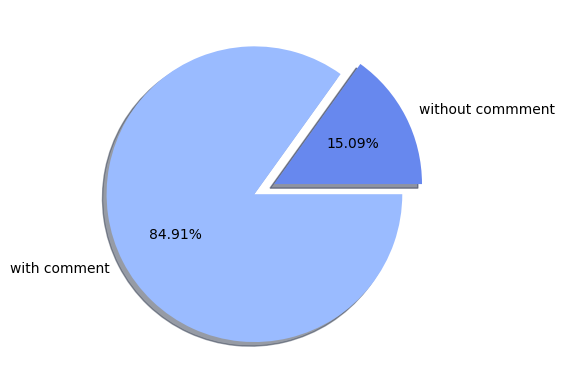

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
explode = [0.15, 0]
plt.pie(
    df_data1.groupby('commented')['ratingSummary'].count(), 
    labels=['without commment', 'with comment'],
    explode = explode,
    shadow = True,
    autopct = '%1.2f%%',
    colors = sns.color_palette("coolwarm")
)
plt.show()

In [121]:
df_data1.columns

Index(['reviewDate', 'customerName', 'ratingSummary', 'comment', 'year',
       'month', 'day', 'commented', 'commented2'],
      dtype='object')

In [165]:
df_data.rename(columns={'Saat nginep di sini, apa jenis perjalananmu?' : 'tripType'}, inplace=True)

In [166]:
df_data.columns

Index(['submitId', 'startJourney', 'endJourney', 'ratingSummary',
       'customerName', 'fake', 'comments', 'userReviewAnswers', 'userImages',
       'totalLike', 'reported', 'totalItems', 'likedByMe', 'reviewDate',
       'reviewSource', 'RatingKebersihan', 'Kebersihan', 'RatingPelayanan',
       'Pelayanan', 'RatingLokasi', 'Lokasi', 'RatingFasilitas', 'Fasilitas',
       'RatingSesuai Harga', 'Sesuai Harga', 'RatingKepantasan harga',
       'Kepantasan harga', 'RatingLayanan', 'Layanan',
       'RatingSaat nginep di sini, apa jenis perjalananmu?', 'tripType',
       'stay_length'],
      dtype='object')

In [169]:
df_data.groupby(
    df_data.reviewDate.apply(lambda x:datetime.fromtimestamp(x/1000)).dt.month
)[['ratingSummary', 'tripType']].agg({'ratingSummary' :'mean', 'tripType': lambda x:x.mode().iloc[0]})

ratingSummary tripType
reviewDate                        
1                4.255639  Lainnya
2                4.262069  Lainnya
3                4.357303  Lainnya
4                4.298851  Lainnya
5                4.164912  Lainnya
6                4.080734  Lainnya
7                4.212598  Lainnya
8                4.367407  Lainnya
9                4.302222  Lainnya
10               4.266667  Lainnya
11               4.131646  Lainnya
12               4.152846  Lainnya

c:\Users\jonat\Downloads\New folder\selenium test\tutorial\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jonat\Downloads\New folder\selenium test\tutorial\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jonat\Downloads\New folder\selenium test\tutorial\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jonat\Downloads\New folder\selenium test\tutorial\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categoric

<Axes: xlabel='month', ylabel='Count'>

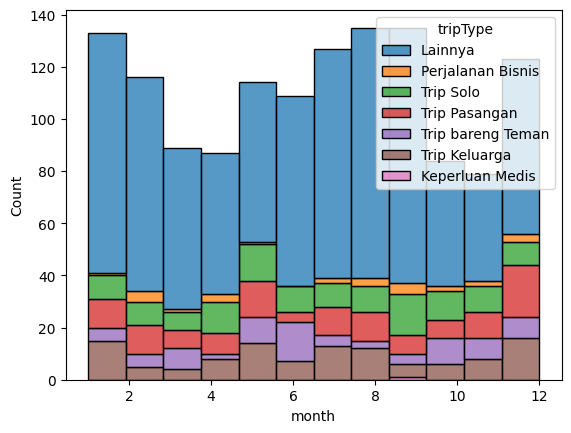

In [179]:
# df_data['month']
sns_data = df_data.groupby(
    df_data.reviewDate.apply(lambda x:datetime.fromtimestamp(x/1000)).dt.month
)[['ratingSummary', 'tripType']].agg({'ratingSummary' :'mean', 'tripType': lambda x:x.mode().iloc[0]}).reset_index()
df_data['month']=df_data.reviewDate.apply(lambda x : datetime.fromtimestamp(x/1000)).dt.month
sns.histplot(df_data, x='month',hue='tripType', multiple='stack')

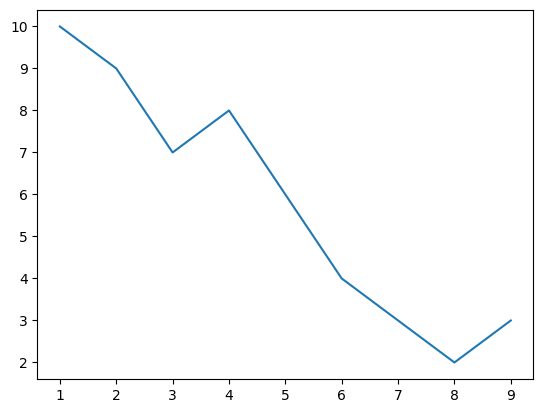

In [139]:
plt.plot(df_data1[df_data1['year'] == datetime.now().year].groupby('month').count()['customerName'])

47 53 69


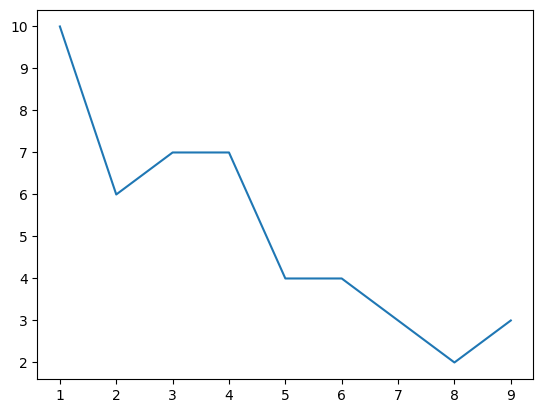

In [138]:
df_unique = df_data1.sort_values('reviewDate').drop_duplicates('customerName')
print(len(df_unique), len(df_data1), len(df))
# print(df_unique.groupby('reviewDate').count()['customerName'])

plt.plot(df_unique[df_unique['year'] == datetime.now().year].groupby('month').count()['customerName'])

c:\Users\jonat\Downloads\New folder\selenium test\tutorial\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jonat\Downloads\New folder\selenium test\tutorial\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jonat\Downloads\New folder\selenium test\tutorial\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jonat\Downloads\New folder\selenium test\tutorial\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categoric

<Axes: xlabel='month', ylabel='ratingSummary'>

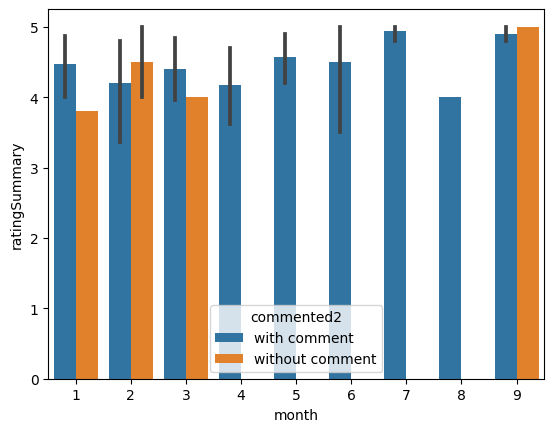

In [58]:
df_data1['commented2'] = df_data1['commented'].apply(lambda x: "with comment" if x==True else "without comment")
sns.barplot(
    data=df_data1[df_data1['year'] == datetime.now().year],
    x="month",
    y="ratingSummary",
    hue="commented2"
)

(0.0, 12.0)

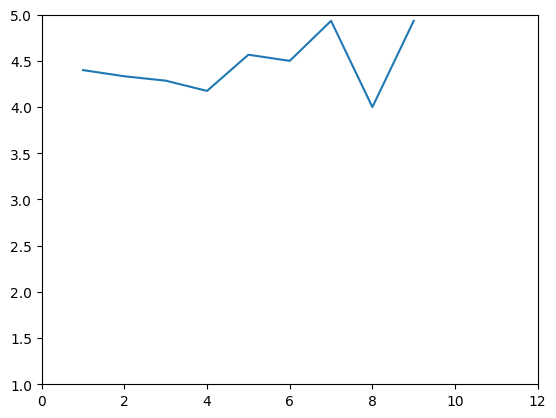

In [24]:
# import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(df_data1[df_data1['year'] == datetime.now().year].groupby(['month'])['ratingSummary'].mean())
plt.ylim((1,5))
plt.xlim((0,12))

In [3]:
# Import the required modules
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
import time
import json
import undetected_chromedriver as uc


from time import sleep

# from selenium import webdriver
# from selenium.webdriver import DesiredCapabilities
if __name__ == "__main__":
# make chrome log requests
    desired_capabilities = DesiredCapabilities.CHROME
    desired_capabilities["goog:loggingPrefs"] = {"performance": "ALL"}  # newer: goog:loggingPrefs
    options = uc.ChromeOptions()
    
    # Chrome will start in Headless mode
    options.add_argument('headless')

    # Ignores any certificate errors if there is any
    options.add_argument("--ignore-certificate-errors")
    
    driver = uc.Chrome(
        options=options,
        desired_capabilities=desired_capabilities
    )

    # fetch a site that does xhr requests
    driver.get("https://www.tiket.com/review?product_type=TIXHOTEL&searchType=INVENTORY&inventory_id=infinity8-bali-506001655965152937&reviewSubmitColumn=RATING_SUMMARY&hideToolbar=null")
    sleep(5)  # wait for the requests to take place

    # extract requests from logs
    logs_raw = driver.get_log("performance")
    logs = [json.loads(lr["message"])["message"] for lr in logs_raw]

    def log_filter(log_):
        return (
            # is an actual response
            log_["method"] == "Network.responseReceived"
            # and json
            and "json" in log_["params"]["response"]["mimeType"]
        )
    i = 0
    for log in filter(log_filter, logs):
        request_id = log["params"]["requestId"]
        resp_url = log["params"]["response"]["url"]
        print(f"Caught {resp_url}")
        # print(driver.execute_cdp_cmd("Network.getResponseBody", {"requestId": request_id}))
        with open(f"net_{i}.json", "w") as f:
            f.write(json.dumps(driver.execute_cdp_cmd("Network.getResponseBody", {"requestId": request_id})))
            i+=1



could not detect version_main.therefore, we are assuming it is chrome 108 or higher


Caught https://www.tiket.com/ms-gateway/tix-review-core/verticalReview/image-with-comments?inventoryId=infinity8-bali-506001655965152937&productType=TIXHOTEL&page=0&size=100&lang=id
Caught https://www.tiket.com/ms-gateway/tix-review-core/verticalReview/internalReview?page=0&size=5&productType=TIXHOTEL&reviewSubmitColumn=RATING_SUMMARY&sortDirection=DESC&topic=&searchType=INVENTORY&inventoryId=infinity8-bali-506001655965152937
Caught https://www.tiket.com/ms-gateway/tix-members-core/account/basic/v2
Caught https://api.lab.amplitude.com/sdk/vardata


In [12]:
with open("net_0.json", "r") as f:
    g = json.loads(json.loads(f.read())['body'])

g['data']

{'content': [{'reviewId': '65052f4da1ab550001f17e1c',
   'imageUrl': 'https://s-light.tiket.photos/t/01E25EBZS3W0FY9GTG6C42E1SE/rsfit10801920gsm/images/2023/09/16/f2f57d1b-67a0-4055-a41d-92c1f95a9c14-1694838568801-b057c4c840e16171791aa609639c87ad.jpg',
   'reviewDate': 1694838605387,
   'customerName': 'nimas rofah',
   'ratingSummary': 5.0},
  {'reviewId': '64f52607afb3320001b6ea84',
   'imageUrl': 'https://s-light.tiket.photos/t/01E25EBZS3W0FY9GTG6C42E1SE/rsfit10801920gsm/images/2023/09/04/1cb64592-ed5c-4d9a-8f29-9ac52d38ad18-1693787646983-40a1f997ec2ffb4a95b5ed8b42bc50b3.jpg',
   'reviewDate': 1693787655979,
   'customerName': 'Alvin Suhardjhono',
   'ratingSummary': 5.0},
  {'reviewId': '64f46b5ab4513a000168db2e',
   'imageUrl': 'https://s-light.tiket.photos/t/01E25EBZS3W0FY9GTG6C42E1SE/rsfit10801920gsm/images/2023/09/03/299097fb-a7fe-4cc0-9fd3-410b928f26b8-1693739851476-e32f13139d47fcc69f8a657af65c6a63.jpg',
   'reviewDate': 1693739866194,
   'customerName': 'AS',
   'ratingSummar

In [ ]:
len(g['data']['content']), len(g['data']['comments'])
import pandas as pd
df = pd.DataFrame(g['data']['content'])
df2 = pd.DataFrame(g['data']['comments'])


In [25]:
df2.columns

Index(['reviewId', 'questionCode', 'questionTitle', 'value'], dtype='object')

In [26]:
df3 = df.join(df2[['reviewId','value']].set_index('reviewId'), on='reviewId')

In [30]:
df3.groupby("customerName").mean()

TypeError: agg function failed [how->mean,dtype->object]

In [20]:
import pandas as pd

df = pd.DataFrame(g['data']['content'])
df

reviewId  \
0   65052f4da1ab550001f17e1c   
1   64f52607afb3320001b6ea84   
2   64f46b5ab4513a000168db2e   
3   64e20dcab54cd00001ca4afa   
4   64dcceed54e52a0001dd3f10   
..                       ...   
95  63b0a70dc2435900013434fa   
96  63b0a70dc2435900013434fa   
97  63b032a4b2bf890001983b14   
98  63b032a4b2bf890001983b14   
99  63b032a4b2bf890001983b14   

                                             imageUrl     reviewDate  \
0   https://s-light.tiket.photos/t/01E25EBZS3W0FY9...  1694838605387   
1   https://s-light.tiket.photos/t/01E25EBZS3W0FY9...  1693787655979   
2   https://s-light.tiket.photos/t/01E25EBZS3W0FY9...  1693739866194   
3   https://s-light.tiket.photos/t/01E25EBZS3W0FY9...  1692536266027   
4   https://s-light.tiket.photos/t/01E25EBZS3W0FY9...  1692192493342   
..                                                ...            ...   
95  https://s-light.tiket.photos/t/01E25EBZS3W0FY9...  1672521485069   
96  https://s-light.tiket.photos/t/01E25EBZS3W0FY9...  1672521485069   
97  https://s-light.tiket.photos/t/01E25EBZS3W0FY9...  1672491684078   
98  https://s-light.tiket.photos/t/01E25EBZS3W0FY9...  1672491684078   
99  https://s-light.tiket.photos/t/01E25EBZS3W0FY9...  1672491684078   

           customerName  ratingSummary  
0           nimas rofah            5.0  
1     Alvin Suhardjhono            5.0  
2                    AS            4.8  
3   Ferditasus Meisaroh            4.0  
4                    JA            4.0  
..                  ...            ...  
95     Nelpa Mayangsari            5.0  
96     Nelpa Mayangsari            5.0  
97    Yuni Setyaningsih            4.8  
98    Yuni Setyaningsih            4.8  
99    Yuni Setyaningsih            4.8  

[100 rows x 5 columns]

In [4]:
with open('network_log.json', 'r') as f:
    fx = json.loads(f.read())
    print(fx)

# print(fx)

[{'method': 'Network.responseReceived', 'params': {'frameId': 'DB037A819BD65934322F7CC9C6003D80', 'hasExtraInfo': False, 'loaderId': '362AF74E8BA8DA9F58D454B22FD7D00F', 'requestId': '2076.2', 'response': {'alternateProtocolUsage': 'alternativeJobWonWithoutRace', 'connectionId': 0, 'connectionReused': False, 'encodedDataLength': -1, 'fromDiskCache': False, 'fromPrefetchCache': False, 'fromServiceWorker': False, 'headers': {'Cache-Control': 'no-cache', 'Content-Security-Policy': "child-src 'none';object-src 'none';require-trusted-types-for 'script';script-src chrome://resources 'self';trusted-types;worker-src blob: 'self';frame-ancestors 'none';", 'Content-Type': 'text/css', 'X-Frame-Options': 'DENY'}, 'mimeType': 'text/css', 'protocol': 'chrome', 'securityState': 'unknown', 'status': 200, 'statusText': 'OK', 'url': 'chrome://resources/css/md_colors.css'}, 'timestamp': 98693.625785, 'type': 'Stylesheet'}}, {'method': 'Network.responseReceived', 'params': {'frameId': 'DB037A819BD65934322F

In [10]:
fx[5]

{'method': 'Network.responseReceived',
 'params': {'frameId': 'DB037A819BD65934322F7CC9C6003D80',
  'hasExtraInfo': False,
  'loaderId': '362AF74E8BA8DA9F58D454B22FD7D00F',
  'requestId': '2076.10',
  'response': {'alternateProtocolUsage': 'alternativeJobWonWithoutRace',
   'connectionId': 0,
   'connectionReused': False,
   'encodedDataLength': -1,
   'fromDiskCache': False,
   'fromPrefetchCache': False,
   'fromServiceWorker': False,
   'headers': {'Cache-Control': 'no-cache',
    'Content-Security-Policy': "child-src 'none';object-src 'none';require-trusted-types-for 'script';script-src chrome://resources 'self';trusted-types;worker-src blob: 'self';frame-ancestors 'none';",
    'Content-Type': 'text/css',
    'X-Frame-Options': 'DENY'},
   'mimeType': 'text/css',
   'protocol': 'chrome',
   'securityState': 'secure',
   'status': 200,
   'statusText': 'OK',
   'url': 'chrome://resources/css/roboto.css'},
  'timestamp': 98693.640829,
  'type': 'Stylesheet'}}